## Generating Individualised TMS Electric Field using SimNIBS


#### Inputs required

1. head model: a .msh file \
    1.1 Made using T1 and T2(optional) scan.
2. a coil model
3. position of coil
4. Strength of electric field

#### Outputs obtained
Electric field stregth over HCP atlas regions in .json

#### What's done in this notebook?
1. uses simNIBS default ernie data
2. coil placed on \
    2.1) right motor cortex over FC6 electrode[15] \
    2.2) left motor cortex using MNI coordinates.

3. Option to change orientation of coil when using MNI coordinates
4. Electric field \
    4.1 Simulation \
    4.2 Transformation for HCP atlas by weighted averaging over regions \
    4.3 Saving as .json for use in TVB \

CAUTION: run this notebook in a simnibs env.

In [1]:
from simnibs import sim_struct, run_simnibs, read_msh
import simnibs
import nilearn.image as img
import nilearn.plotting as niplot
import os
import numpy as np
from numpy import degrees, arcsin, arctan2, deg2rad, cos, sin

### Making head model

1. Run headreco with T1 and ideally T2 also. [needs Matlab and SPM12]
```
headreco --all <subject> path/to/T1/image.nii.gz

```

NOTE: Pipeline tested using Anuja's T1 scan! Took 2 hours to run on my local setup.

### Simulating the electric field 

In [2]:
# Initalize a session
s = sim_struct.SESSION()
# Name of head mesh
s.fnamehead = './data/simnibs_examples/ernie/ernie.msh'
# Output folder
s.pathfem = './data/electric_fields/ernie/'
s.fields = 'e'
s.map_to_surf = True
# s.map_to_fsavg = True
s.map_to_MNI = True
s.open_in_gmsh = False

In [3]:
import os
if not os.path.exists(s.pathfem):
    os.makedirs(s.pathfem)


**Coil model**

In [4]:
from simnibs import SIMNIBSDIR
# Initialize a list of TMS simulations
tmslist = s.add_tmslist()
# Select coil
tmslist.fnamecoil = 'Magstim_70mm_Fig8.nii.gz'


**Coil Position and Orientation**

In [5]:
pos = tmslist.add_position()

In [7]:
#for right M1 using electrode as reference

# Select coil centre
pos.centre = 'FC6' # right M1
# Select coil direction
pos.pos_ydir = 'AF8'

run_simnibs(s)


[ simnibs ]INFO: Head Mesh: /home/anujanegi/tj/TMS-simulation/data/simnibs_examples/ernie/ernie.msh
[ simnibs ]INFO: Subject Path: /home/anujanegi/tj/TMS-simulation/data/simnibs_examples/ernie/m2m_ernie
[ simnibs ]INFO: Simulation Folder: /home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie
[ simnibs ]INFO: Running simulations in the directory: /home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie
[ simnibs ]INFO: Running Poslist Number: 1
[ simnibs ]INFO: Began to run TMS simulations
[ simnibs ]INFO: Coil file: /home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/simnibs/ccd-files/Magstim_70mm_Fig8.nii.gz
[ simnibs ]INFO: Using isotropic conductivities
[ simnibs ]INFO: Calculating Coil position from (centre, pos_y, distance)
[ simnibs ]INFO: matsimnibs: 
[[-0.3758 -0.1392 -0.9162 77.0505]
 [ 0.2893  0.9216 -0.2587 19.0391]
 [ 0.8804 -0.3622 -0.3061 54.9009]
 [ 0.      0.      0.      1.    ]]
[ simnibs ]INFO: coil-cortex distance: 18.81mm
[ simnibs ]IN

['/home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie/ernie_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.msh']

In [55]:
#for left M1 using MNI coords are reference

# left M1 MNI coordinates: x, y, z = −28, −28, 68) https://academic.oup.com/cercorcomms/article/1/1/tgaa085/5957898

# MNI coordinates transformed into subject space
!mni2subject_coords -m ./data/simnibs_examples/ernie/m2m_ernie/ \
    -c "-28" "-28" "23" \
    -t nonl

Transformed coodinates:
[-29.09 -30.97 48.24]


In [56]:
import simnibs.msh.transformations as transformations
from simnibs.msh import mesh_io

subject_coords = [-29.09, -30.97, 48.24]
mesh = mesh_io.read_msh('./data/simnibs_examples/ernie/ernie.msh')
# project to scalp
scalp_coords = transformations.project_on_scalp(
    coords = subject_coords,
    mesh=mesh,
    distance=1
)
print(scalp_coords)

[-76.8348 -38.0853  66.2638]


Left M1 MNI coords projected on subject:


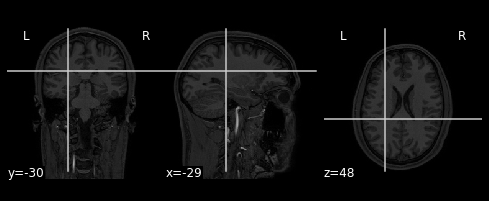

In [57]:
t1 = img.load_img('./data/simnibs_examples/ernie/m2m_ernie/T1fs_nu_conform.nii.gz')

print('Left M1 MNI coords projected on subject:')
niplot.plot_anat(t1, cut_coords=subject_coords)

Left M1 projected on subject's scalp:


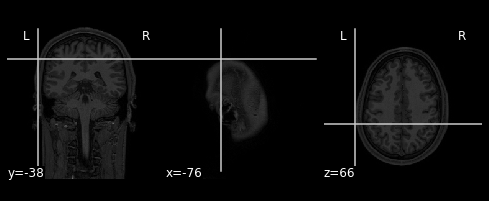

In [58]:
print("Left M1 projected on subject's scalp:")
niplot.plot_anat(t1, cut_coords=scalp_coords)

In [22]:
# Compute the normal of the scalp right under-neath the coil
closest_node, node_index = mesh.nodes.find_closest_node([scalp_coords],
                                           return_index=True)
print(closest_node, node_index)
node_index = node_index[0]

node_normal = mesh.nodes_normals(smooth=2).value[node_index]
print(node_normal)



[[-75.9158 -37.9368  65.8985]] [420933]
[-0.9383 -0.1269  0.3217]


In [23]:
def get_matsimnibs(n,twist,centre):
    
    # Compute euler angles
    alpha = arctan2(-n[1],n[2])
    beta = arcsin(n[0])
    gamma = deg2rad(twist)
    
    # Define rotation matrices for XYZ variant of 
    # tait-bryan rotation matrices 
    R_ap = np.array([
        [1, 0, 0],
        [0, cos(alpha), -sin(alpha)],
        [0, sin(alpha), cos(alpha)]
    ])
    
    R_lr = np.array([
        [cos(beta), 0, sin(beta)],
        [0, 1, 0],
        [-sin(beta), 0, cos(beta)]
    ])
    
    R_tw = np.array([
        [cos(gamma), -sin(gamma), 0],
        [sin(gamma), cos(gamma), 0],
        [0, 0, 1]
    ])
    
    # Get full rotation matrix of coil onto scalp plane
    # @ is matrix multiplication
    R = R_ap @ R_lr @ R_tw
    
    # Invert normal and X to maintain right-handedness
    R[:3,1] = -R[:3,1]
    R[:3,2] = -R[:3,2]
  
    # Construct matsimnibs
    msn = np.zeros((4,4))
    msn[:3,:3] = R
    msn[:3,3] = centre
    
    return msn


In [29]:
# target left M1, coil pointing poteriorly, angle away from midline at 45 degrees
pos.matsimnibs=get_matsimnibs(node_normal,twist=155,centre=scalp_coords)
s.pathfem = './data/electric_fields/ernie−leftM1/'

run_simnibs(s)

[ simnibs ]INFO: Head Mesh: /home/anujanegi/tj/TMS-simulation/data/simnibs_examples/ernie/ernie.msh
[ simnibs ]INFO: Subject Path: /home/anujanegi/tj/TMS-simulation/data/simnibs_examples/ernie/m2m_ernie
[ simnibs ]INFO: Simulation Folder: /home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie−leftM1
[ simnibs ]INFO: Running simulations in the directory: /home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie−leftM1
[ simnibs ]INFO: Running Poslist Number: 1
[ simnibs ]INFO: Began to run TMS simulations
[ simnibs ]INFO: Coil file: /home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/simnibs/ccd-files/Magstim_70mm_Fig8.nii.gz
[ simnibs ]INFO: Using isotropic conductivities
[ simnibs ]INFO: matsimnibs: 
[[ -0.3134   0.1461   0.9383 -76.8348]
 [  0.7051   0.6976   0.1269 -38.0853]
 [ -0.6361   0.7014  -0.3217  66.2638]
 [  0.       0.       0.       0.    ]]
[ simnibs ]INFO: coil-cortex distance: 14.05mm
[ simnibs ]INFO: Assembling FEM Matrx
[ simnibs ]INFO: 15

['/home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie−leftM1/ernie_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.msh']

## Avg nodes over HCP atlas and save

In [33]:
# tms_msh = read_msh('./data/electric_fields/ernie FC6/subject_overlays/ernie_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar_central.msh')
tms_msh = read_msh('./data/electric_fields/ernie−leftM1/subject_overlays/ernie_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar_central.msh')

atlas = simnibs.subject_atlas('HCP_MMP1', './data/simnibs_examples/ernie/m2m_ernie')

EF_result = {}
for areas, values in atlas.items():
    # define ROI 
    if 'unknown' in areas or '???' in areas:
        continue
    roi = atlas[areas]
    
    # calculate nodes areas in ROI for averaging
    node_areas = tms_msh.nodes_areas()
    if not node_areas[roi].any():
        print(areas, node_areas[roi])
        EF_result[areas] = 0
        continue

    # Calculate mean electric field in each region
    field_name = 'normE'
    mean_normE = np.average(tms_msh.field[field_name][roi], weights=node_areas[roi])
    EF_result[areas] = mean_normE

import json
# with open('./data/electric_fields/ernie FC6/ernie_EF_normE.json', 'w') as fp:
with open('./data/electric_fields/ernie−leftM1/ernie_EF_normE.json', 'w') as fp:
    json.dump(EF_result, fp)
